# The Boundaries of the Ocean
- Before dealing with the water itself, let's first examine `the space` that the water lives in. by `ocean bottom(the bathymetry)` and `the top(the free surface)`

### Spatial Coordinates

Longitude: $\varphi$, Latitude: $\lambda$

### Boundaries

Bottom: $H = H(\varphi, \lambda)$
Surface: $\eta = \eta(\varphi, \lambda, t)$
- The ocean has `no side boundaries`

# The vertical coordinate : z
- z=0 at the sea level determined by the `Geoid`
### The Geoid?
- Determined by `distribution of mass` within the Earth and `planetary rotation rate`
- Always `perpendicular to g`
- Varies on O(100m)
### The Free surface?
- deviates from the geoid due to ocean mean circulation, waves..
- Varies on O(1m)
- Negligible contribution to overall ocean volume
### The Bottom
- we will load data (NGDC ETOPO5 database)

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 5)
import hvplot.xarray


In [25]:
import matplotlib.cm as cm

In [2]:
ds = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO5/dods')
ds = ds.rename({'X':'lon', 'Y':'lat'})
ds

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


<xarray.Dataset> Size: 19MB
Dimensions:  (lat: 2160, lon: 4320)
Coordinates:
  * lat      (lat) float32 9kB 90.0 89.92 89.83 89.75 ... -89.75 -89.83 -89.92
  * lon      (lon) float32 17kB 0.0 0.08333 0.1667 0.25 ... 359.8 359.8 359.9
Data variables:
    elev     (lat, lon) int16 19MB ...
Attributes:
    dataset_documentation.html:  http://iridl.ldeo.columbia.edu/SOURCES/.NOAA...
    Conventions:                 IRIDL
    description:                 ETOPO5 5x5 minute land surface elevations an...

In [3]:
# Mask land and retain only ocean bathymetry
ds['elev_ocean'] = ds.elev.where(ds.elev < 0)

# Explicitly load if repeated computations are expected
ds['elev_ocean'].load()

ds

<xarray.Dataset> Size: 56MB
Dimensions:     (lat: 2160, lon: 4320)
Coordinates:
  * lat         (lat) float32 9kB 90.0 89.92 89.83 ... -89.75 -89.83 -89.92
  * lon         (lon) float32 17kB 0.0 0.08333 0.1667 0.25 ... 359.8 359.8 359.9
Data variables:
    elev        (lat, lon) int16 19MB -4290 -4290 -4290 -4290 ... 2774 2774 2774
    elev_ocean  (lat, lon) float32 37MB -4.29e+03 -4.29e+03 ... nan nan
Attributes:
    dataset_documentation.html:  http://iridl.ldeo.columbia.edu/SOURCES/.NOAA...
    Conventions:                 IRIDL
    description:                 ETOPO5 5x5 minute land surface elevations an...

In [4]:
# plotting

ds.elev_ocean.hvplot('lon', 'lat',
                     clim=(-8000, 0), 
                     rasterize = True, 
                     height = 500,
                     width = 1000,
                     cmap = 'ocean')

BokehModel(combine_events=True, render_bundle={'docs_json': {'d08b959b-87f2-480f-8d2e-2703ffbfbd2c': {'version…

## The Ocean Volume

Assuming spherical geometry

\begin{align}
  \mathcal{V} &= \iiint_{ocean} dV  \\
      &= \int_{-\pi}^{\pi} \int_{0}^{2 \pi} R^2 \cos(\lambda)d\lambda d \phi \int_{-H}^\eta dz \\
      &= \iint_{surface} (\eta + H)(\lambda, \phi) dA
\end{align}

Area element: $dA = R^2 \cos(\lambda)d\lambda d \phi$

- $dV -> (\lambda, \phi, z$)
- $dA = (R \cos(\lambda) d\phi) \times (R d\lambda) = R^2 \cos(\lambda) d\lambda d\phi$

`accurate equation`: $\int_{\phi_1}^{\phi_2} \cos(\phi) d\phi = \sin(\phi_2) - \sin(\phi_1)$

`Crude equation`: $\approx \cos(\frac{\phi_1+\phi_2}{2}) \cdot (\phi_2 - \phi_1)$

In [9]:
# Create a crude area(rough) weight factor based on assumption of spherical geometry

earth_radious = 6.371e6
tot_area = 4*np.pi*earth_radious**2
dlon = np.radians((ds['lon'][1] - ds['lon'][0]).values) 
dlat = np.radians((ds['lat'][1] - ds['lat'][0]).values)

# calculate 1D
area_1d = earth_radious**2 * np.abs(dlon * dlat) * np.cos(np.radians(ds.lat))

# expanding 1D -> 2D
ds['area'], _ = xr.broadcast(area_1d, ds.elev)

ds['area_ocean'] = ds.area.where(ds.elev < 0)

ds['area_ocean']

<xarray.DataArray 'area_ocean' (lat: 2160, lon: 4320)> Size: 37MB
array([[-3.7533178e+00, -3.7533178e+00, -3.7533178e+00, ...,
        -3.7533178e+00, -3.7533178e+00, -3.7533178e+00],
       [ 1.2489605e+05,  1.2489605e+05,  1.2489605e+05, ...,
         1.2489605e+05,  1.2489605e+05,  1.2489605e+05],
       [ 2.4977508e+05,  2.4977508e+05,  2.4977508e+05, ...,
         2.4977508e+05,  2.4977508e+05,  2.4977508e+05],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]],
      shape=(2160, 4320), dtype=float32)
Coordinates:
  * lat      (lat) float32 9kB 90.0 89.92 89.83 89.75 ... -89.75 -89.83 -89.92
  * lon      (lon) float32 17kB 0.0 0.08333 0.1667 0.25 ... 359.8 359.8 359.9
Attributes:
    pointwidth:     0.08333333
    standard_name:  latitude
    gridtype:       0
    units:          degree_north

- xr.broadcast의 반환 값은 (broadcasted_A, broadcasted_B) 형태의 튜플.
result = xr.broadcast(area_1d, ds.elev) 

- result는 (DataArray, DataArray) 형태

In [ ]:
# Example

da1 = xr.DataArray([1, 2, 3], dims="x", name="data1")
da2 = xr.DataArray([[10, 20], [30, 40], [50, 60]], dims=("x", "y"), name="data2")

In [10]:
# test to verity it
np.testing.assert_allclose(ds.area.sum().values, tot_area, rtol=1e-4)

Text(0.5, 1.0, '-8000m to 0m hist')

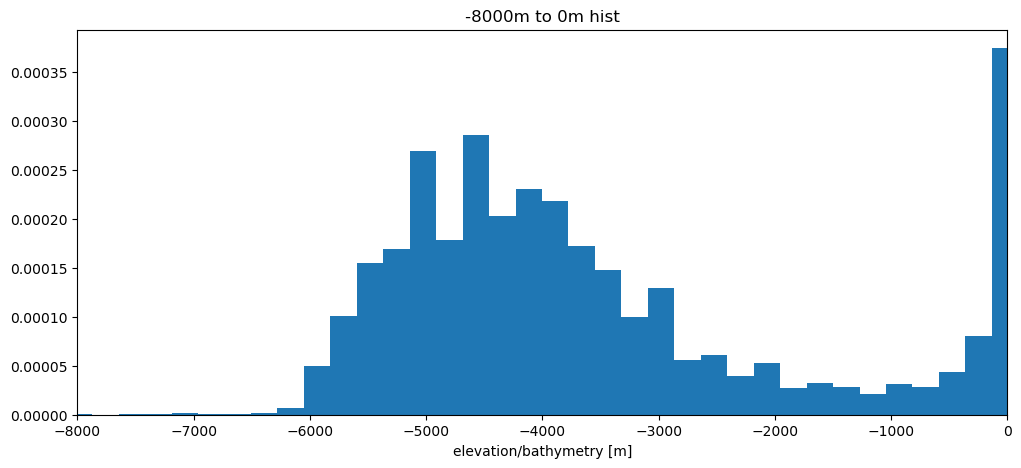

In [16]:
# How it the depth distributed? -> make a `histogram`

fig, ax = plt.subplots()
ds['elev'].plot.hist(bins = 80, weights = ds['area'].values.ravel(), density=True, ax=ax)
ax.set_xlim([-8000, 0])
ax.set_title("-8000m to 0m hist")

In [19]:
# 1. Prepare area weights: Replace NaNs (land mask) with 0 to prevent calculation errors.
#    This ensures that land points do not contribute to the weighted statistics.
weights = ds.area_ocean.fillna(0)

# 2. Calculate the fraction of Earth's surface covered by the ocean.
#    (Total Ocean Area / Total Earth Surface Area)
print('Fraction of Earth covered by Ocean: ', ds.area_ocean.sum().values / tot_area)

# 3. Calculate the global mean ocean depth.
#    Using .weighted(weights) is crucial to account for the varying grid cell areas 
#    on a spherical Earth (smaller areas at poles, larger at equator).
print('Mean Ocean Depth: ', float(ds.elev_ocean.weighted(weights).mean()), 'm')

# 4. Find the maximum ocean depth.
#    Since elevation is negative below sea level, the minimum value corresponds to the deepest point.
print('Max Ocean Depth: ', float(ds.elev_ocean.min()), 'm')

# 5. Calculate the total ocean volume.
#    .weighted(weights).sum() effectively computes the volume integral: sum(depth * area).
#    The negative sign is applied to convert negative elevation to positive volume.
print('Total Ocean Volume: ', -float(ds.elev_ocean.weighted(weights).sum()), 'm^3')

Fraction of Earth covered by Ocean:  0.71395725
Mean Ocean Depth:  -3674.6533203125 m
Max Ocean Depth:  -10376.0 m
Total Ocean Volume:  1.3381775315760579e+18 m^3


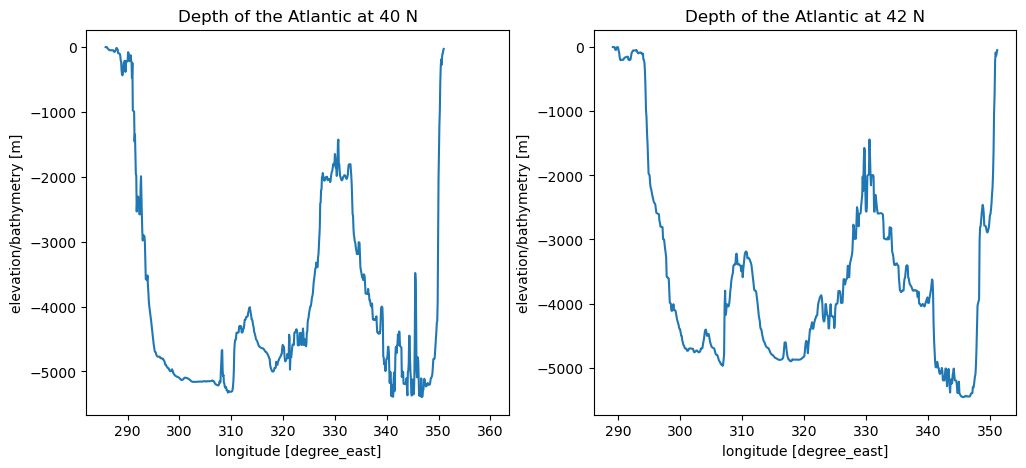

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ds.elev_ocean.sel(lat=40, method='nearest').sel(lon=slice(270, 360)).plot(ax=ax1)
ds.elev_ocean.sel(lat=42, method='nearest').sel(lon=slice(270, 360)).plot(ax=ax2)

ax1.set_title('Depth of the Atlantic at 40 N')
ax2.set_title('Depth of the Atlantic at 42 N')

plt.show()

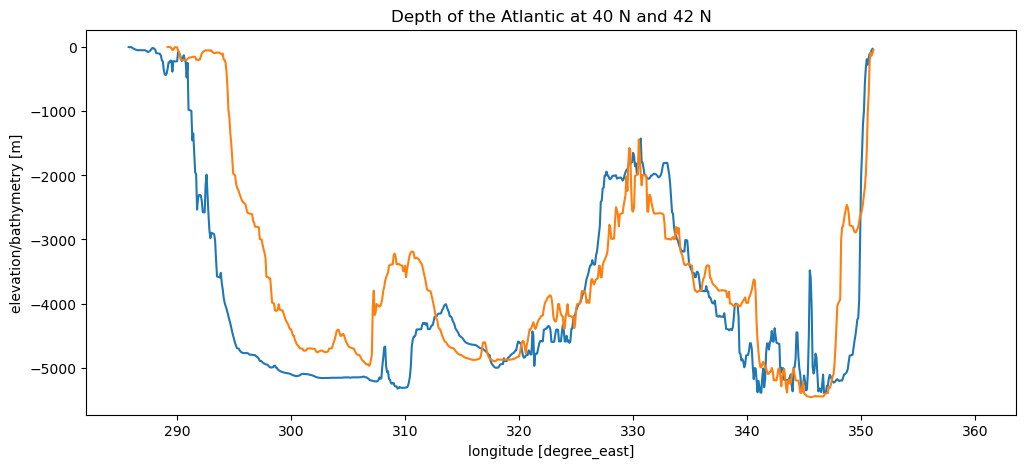

In [24]:
fig, ax = plt.subplots()

ds.elev_ocean.sel(lat=40, method='nearest').sel(lon=slice(270, 360)).plot(ax=ax)
ds.elev_ocean.sel(lat=42, method='nearest').sel(lon=slice(270, 360)).plot(ax=ax)

ax.set_title('Depth of the Atlantic at 40 N and 42 N')

plt.show()

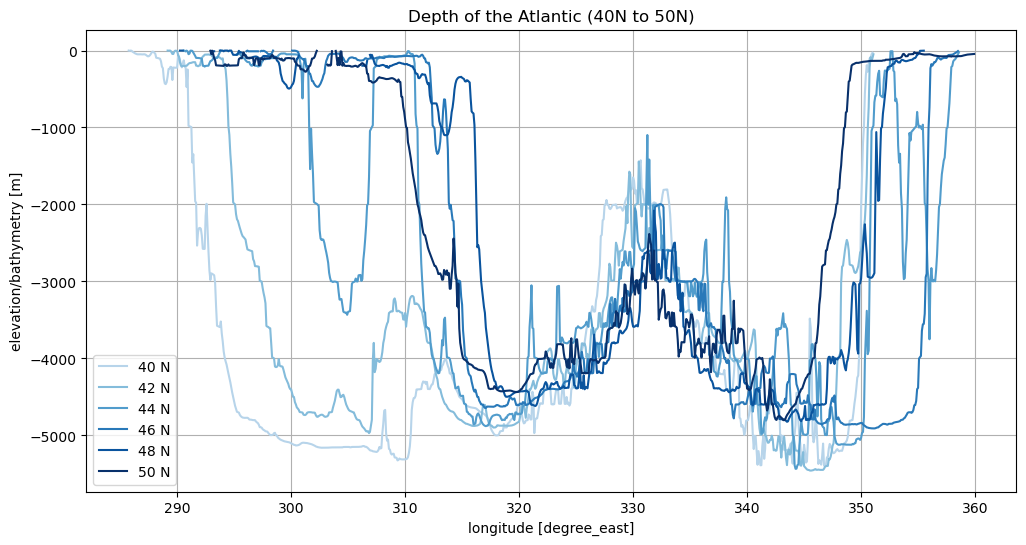

In [28]:
target_lats = [40, 42, 44, 46, 48, 50]

colors = cm.Blues(np.linspace(0.3, 1.0, len(target_lats)))

# plotting, zip 활용해서 match.
fig, ax = plt.subplots(figsize=(12, 6))
for lat, color in zip(target_lats, colors):
    ds.elev_ocean.sel(lat=lat, method='nearest') \
    .sel(lon=slice(270, 360)) \
    .plot(ax=ax, color=color, label = f'{lat} N')
    
ax.set_title('Depth of the Atlantic (40N to 50N)')
ax.legend()
ax.grid(True)
plt.show()

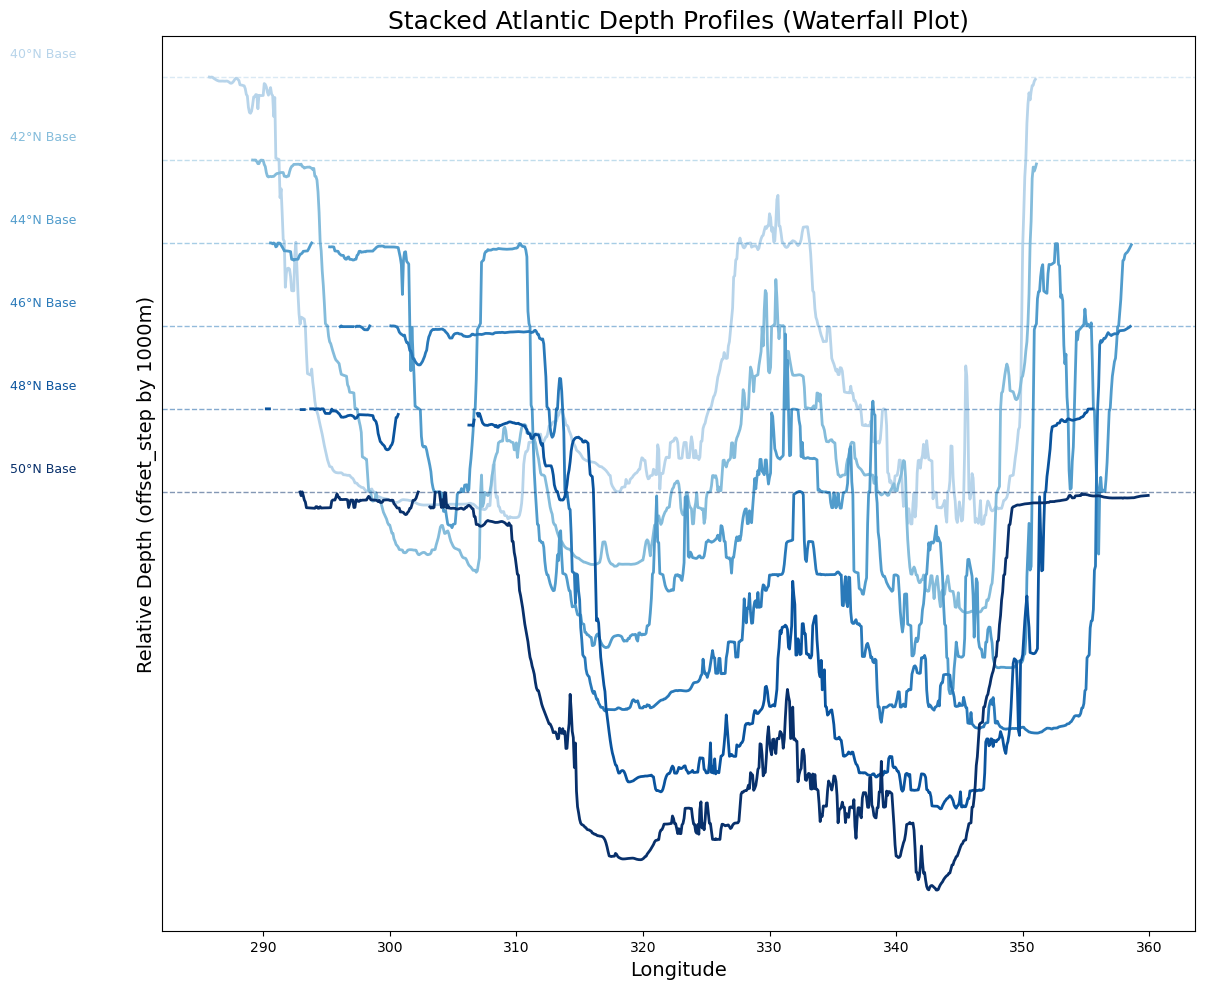

In [ ]:
target_lats = [40, 42, 44, 46, 48, 50]
colors = cm.Blues(np.linspace(0.3, 1.0, len(target_lats)))

# A value of 1000m ensures that profiles do not overlap too much.
offset_step = 1000 # 1000m

fig, ax = plt.subplots(figsize = (12, 10))

# Iterate through latitudes and colors
for i, (lat, color) in enumerate(zip(target_lats, colors)):
    # Extract data for the specific latitude
    data = ds.elev_ocean.sel(lat=lat, method = 'nearest').sel(lon=slice(270, 360))
    # Apply the verical shift, subtracting (i * offset_step)dnleh rud = data - (i * offset_step)
    # Plotting
    vertical_shifted_data.plot(ax=ax, color=color, linewidth=2, label = 'f{lat} N')
    ax.axhline(-i * offset_step, color=color, linestyle='--', alpha=0.5, linewidth=1)
    ax.text(270, -i * offset_step + 200, f'{lat}°N Base', color=color, fontsize=9, va='bottom')

# Finalize the plot aesthetics.
ax.set_title('Stacked Atlantic Depth Profiles (Waterfall Plot)', fontsize=18)
ax.set_xlabel('Longitude', fontsize=14)

ax.set_yticks([])
ax.set_ylabel('Relative Depth (offset_step by 1000m)', fontsize=14)

plt.tight_layout()
plt.show()

# 깊이 별 물의 양 체크도 가능하겠네?
-> 전지구만
-> 쿠로시오 해류만

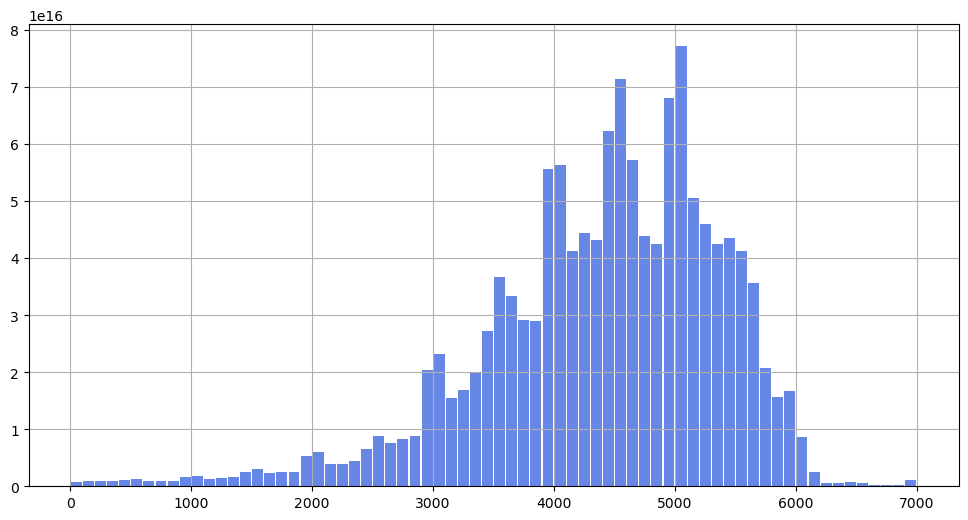

In [35]:
ds['depth'] = -ds['elev_ocean']
ds['volume_cell'] = ds['area_ocean'] * ds['depth']

depth_bins = np.arange(0, 7001, 100)
bin_labels = depth_bins[:-1] + 50

volume_by_depth = ds.volume_cell.groupby_bins(ds['depth'], bins=depth_bins).sum()

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(bin_labels, volume_by_depth, width=90, color='royalblue', alpha=0.8)

ax.grid(True)
plt.show()

In [41]:
# Kuroshio current, Active Layer (~700m) vs Deep Ocean (>700m)

ds['depth'] = -ds['elev_ocean']
ds['volume_cell'] = ds['area_ocean'] * ds['depth']

# 1. Active Layer Volume (0~700m)
# xr.where(condition, True, False)
active_thickness = xr.where(kuroshio['depth'] > threshold_depth, threshold_depth, kuroshio['depth'])
vol_active_real = (kuroshio['area_ocean'] * active_thickness).sum()

# 2. Deep Ocean Volume (>700m) 계산
vol_total = kuroshio['volume_cell'].sum()
vol_deep_real = vol_total - vol_active_real

# 3. Result
print(f"--- Corrected Layer Analysis ---")
print(f"Total Volume: {vol_total.values:.2e} m^3")
print(f"Active Layer (Top 700m): {vol_active_real.values:.2e} m^3 ({vol_active_real/vol_total*100:.1f}%)")
print(f"Deep Layer (Below 700m): {vol_deep_real.values:.2e} m^3 ({vol_deep_real/vol_total*100:.1f}%)")

--- Corrected Layer Analysis ---
Total Volume: 2.16e+16 m^3
Active Layer (Top 700m): 3.74e+15 m^3 (17.3%)
Deep Layer (Below 700m): 1.79e+16 m^3 (82.7%)


In [44]:
# Effective Depth Calculation

def get_effective_depth(da_depth, limit_depth):
    """
    Returns
    - If actual depth > limit : returns limit
    - If actual depth <= limit : returns actual depth
    """
    return xr.where(da_depth > limit_depth, limit_depth, da_depth)

# ==============================================================================
# 1. Compute cumulative depths (200 surface ; 700 intermediate ; 2000 deep) and compute layer thickness
# ==============================================================================
d_200 = get_effective_depth(kuroshio['depth'], 200)
d_700 = get_effective_depth(kuroshio['depth'], 700)
d_2000 = get_effective_depth(kuroshio['depth'], 2000)

thick_surface = d_200
thick_intermediate = d_700 - d_200
thick_deep = d_2000 - d_700
thick_abyssal = kuroshio['depth'] - d_2000
# ==============================================================================
# 2. Calculate Volume for each layer
# ==============================================================================
ku_area = kuroshio['area_ocean']
vol_1 = (ku_area * thick_surface).sum()
vol_2 = (ku_area * thick_intermediate).sum()
vol_3 = (ku_area * thick_deep).sum()
vol_4 = (ku_area * thick_abyssal).sum()

vol_total_calc = vol_1 + vol_2 + vol_3 + vol_4
vol_total_raw = kuroshio['volume_cell'].sum()

# ==============================================================================
# 3. statistics
# ==============================================================================
print(f"--- Kuroshio Region Volume Budget Analysis ---")
print(f"Total Volume (Raw Data): {vol_total_raw.values:.3e} m^3")
print(f"Total Volume (Layer Sum): {vol_total_calc.values:.3e} m^3")
print(f"Discrepancy: {float(vol_total_raw - vol_total_calc):.2e} m^3 (Should be close to 0)\n")

--- Kuroshio Region Volume Budget Analysis ---
Total Volume (Raw Data): 2.163e+16 m^3
Total Volume (Layer Sum): 2.163e+16 m^3
Discrepancy: 4.29e+09 m^3 (Should be close to 0)



In [45]:
# Display percentages for intuitive understanding
p1 = (vol_1 / vol_total_raw * 100).values
p2 = (vol_2 / vol_total_raw * 100).values
p3 = (vol_3 / vol_total_raw * 100).values
p4 = (vol_4 / vol_total_raw * 100).values

print(f"1. Surface Mixed Layer (0-200m):      {vol_1.values:.2e} m^3 ({p1:.1f}%)")
print(f"2. Intermediate Layer (200-700m):     {vol_2.values:.2e} m^3 ({p2:.1f}%)")
print(f"3. Deep Layer (700-2000m):            {vol_3.values:.2e} m^3 ({p3:.1f}%)")
print(f"4. Abyssal Layer (>2000m):            {vol_4.values:.2e} m^3 ({p4:.1f}%)")

1. Surface Mixed Layer (0-200m):      1.15e+15 m^3 (5.3%)
2. Intermediate Layer (200-700m):     2.58e+15 m^3 (11.9%)
3. Deep Layer (700-2000m):            6.12e+15 m^3 (28.3%)
4. Abyssal Layer (>2000m):            1.18e+16 m^3 (54.5%)


## mhw 연구 기초 공사 겸, bathymetry로 advection path랑 heat capacity potential rough하게 구현해보기.

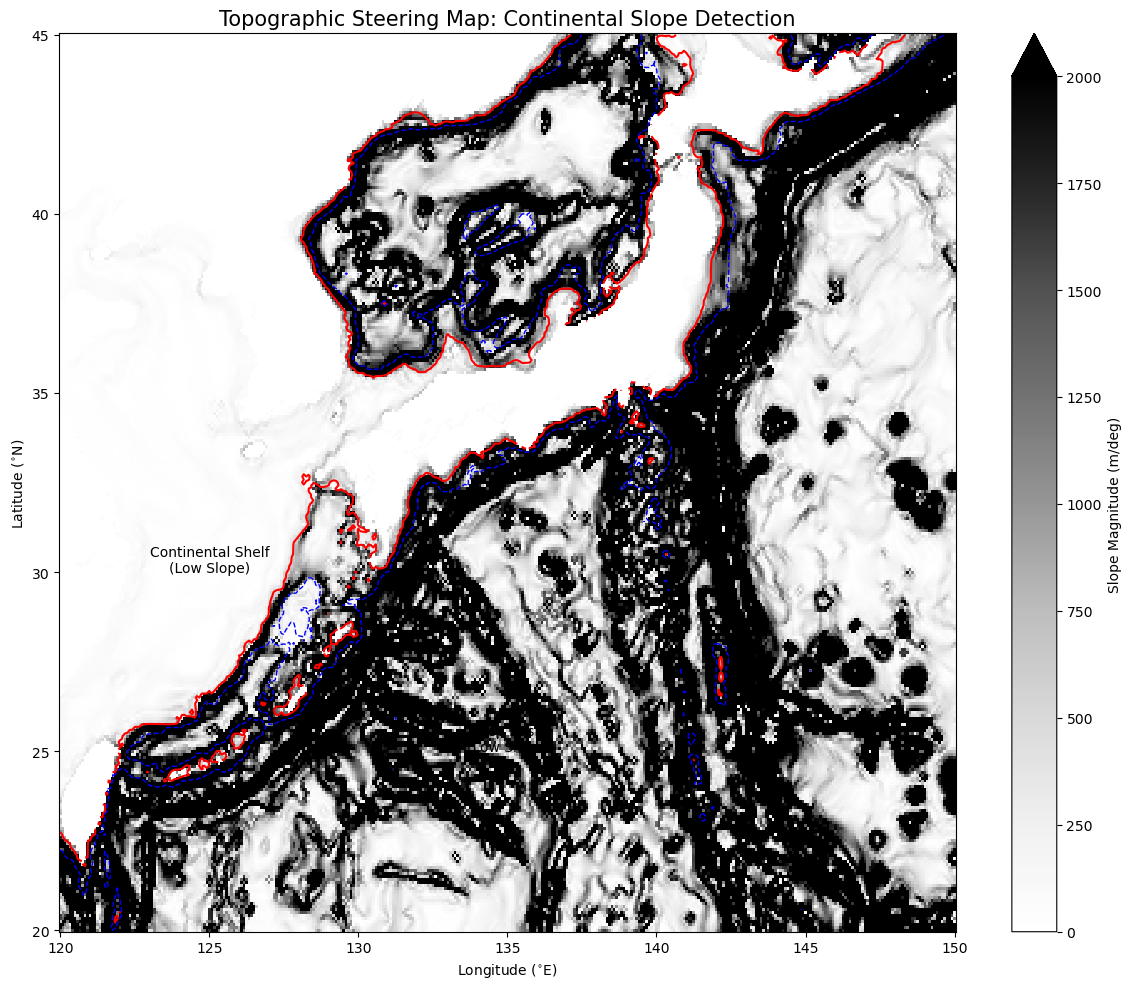

In [51]:
# ==============================================================================
# A. Topograpic steering analysis  (Continential slope)
# ==============================================================================

if kuroshio['depth'].min() < 0 :
    kuroshio['depth'] = -kuroshio['elev_ocean']
    
# ==============================================================================
# 1. Calculate Spatial Gradients 
# ==============================================================================
dd_dx = kuroshio['depth'].differentiate('lon')  # zone gradient
dd_dy = kuroshio['depth'].differentiate('lat')  # meridional gradient

slope_magnitude = np.sqrt(dd_dx**2 + dd_dy**2)


# ==============================================================================
# 2. Visualazation
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 10))

# Plot slope magitude (high value : continental slope)
slope_plot = slope_magnitude.plot(ax=ax,
                                  cmap = 'Greys',
                                  vmin = 0,
                                  vmax = 2000,
                                  add_colorbar=True,
                                  cbar_kwargs={'label' : 'Slope Magnitude (m/deg)'})

# Overlay Isobaths
kuroshio['depth'].plot.contour(ax=ax, levels=[200], colors='red', linewidths=1.5, linestyles='-')
kuroshio['depth'].plot.contour(ax=ax, levels=[1000], colors='blue', linewidths=1.0, linestyles='--')

ax.set_title('Topographic Steering Map: Continental Slope Detection', fontsize=15)
ax.set_xlabel('Longitude ($^{\circ}$E)')
ax.set_ylabel('Latitude ($^{\circ}$N)')
ax.text(125, 30, 'Continental Shelf\n(Low Slope)', color='black', ha='center', fontsize=10)
ax.text(135, 25, 'Deep Basin\n(Low Slope)', color='black', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

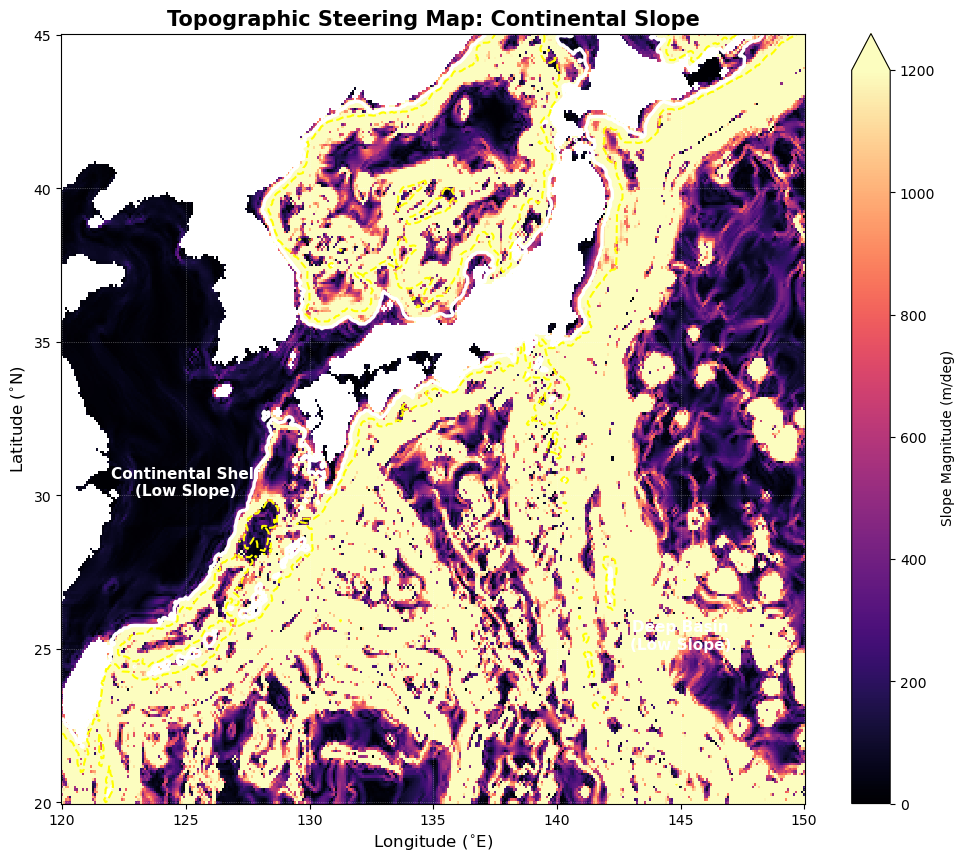

In [53]:
# fix(test)
fig, ax = plt.subplots(figsize=(12, 10))
slope_plot = slope_magnitude.plot(ax=ax, cmap='magma', vmin=0, vmax=1200, 
                                  add_colorbar=True, cbar_kwargs={'label': 'Slope Magnitude (m/deg)'})
kuroshio['depth'].plot.contour(ax=ax, levels=[200], colors='white', linewidths=2.5, linestyles='-')
kuroshio['depth'].plot.contour(ax=ax, levels=[1000], colors='yellow', linewidths=1.5, linestyles='--')
ax.set_title('Topographic Steering Map: Continental Slope', fontsize=15, fontweight='bold')
ax.set_xlabel('Longitude ($^{\circ}$E)', fontsize=12)
ax.set_ylabel('Latitude ($^{\circ}$N)', fontsize=12)

ax.text(125, 30, 'Continental Shelf\n(Low Slope)', color='white', ha='center', fontsize=11, fontweight='bold')
ax.text(145, 25, 'Deep Basin\n(Low Slope)', color='white', ha='center', fontsize=11, fontweight='bold')

ax.grid(True, color='white', linestyle=':', linewidth=0.5, alpha=0.5)

plt.show()